In [22]:
import pandas as pd
from tqdm import tqdm
tqdm.pandas()
import sys

sys.path.append('/work/magroup/kaileyhu/synthetic_lethality/utils')

from extract_df_info import *

import torch
from tqdm import tqdm
import scanpy as sc
import numpy as np

In [23]:
df = pd.read_hdf(
    "/work/magroup/kaileyhu/res/perturbed/gf_12L_30M_i2048_SL/gene2vec_df/perturbed_gene2vec_film_all.h5", "table"
)

In [24]:
path = "/work/magroup/kaileyhu/res/perturbed/gf_12L_30M_i2048_SL/gene2vec_df"

via_df = pd.read_hdf(f"{path}/gene2vec_emb_mat.h5", "table")

In [25]:
df['name'] = df.index
df['viability'] = df['name'].progress_apply(lambda x : via_df['viability score'].loc[x])

100%|██████████| 1951670/1951670 [00:29<00:00, 65754.24it/s]


In [26]:
df['patient'] = list(map(get_patient_name_from_index, list(df.index)))

In [27]:
df['gene'] = list(map(get_genes_from_index, list(df.index)))

In [28]:
all_genes = set(df['gene'])

In [29]:
pathway_map = {
    "BRCA1": "DDR",
    "BRCA2": "DDR",
    "PARP1": "DDR",
    "ATM": "DDR",
    "ATR": "DDR",
    "RAD51": "DDR",
    "CHEK1": "DDR",
    "CDK1": "Cell cycle",
    "CDK2": "Cell cycle",
    "CCNB1": "Cell cycle",
    "CCND1": "Cell cycle",
    "PLK1": "Cell cycle",
    "AURKA": "Cell cycle",
    "AURKB": "Cell cycle",
    "EGFR": "RTK/PI3K",
    "ERBB2": "RTK/PI3K",
    "FGFR1": "RTK/PI3K",
    "PIK3CA": "RTK/PI3K",
    "PIK3CB": "RTK/PI3K",
    "PTEN": "RTK/PI3K",
    "AKT1": "RTK/PI3K",
    "BCL2": "Apoptosis",
    "BCL2L1": "Apoptosis",
    "MCL1": "Apoptosis",
    "BAX": "Apoptosis",
    "BAK1": "Apoptosis",
    "CASP8": "Apoptosis",
    "CASP9": "Apoptosis",
    "KRAS": "Oncogene",
    "NRAS": "Oncogene",
}

In [30]:
import pickle as pkl
ensembl_path = "/work/magroup/kaileyhu/Geneformer/geneformer/ensembl_mapping_dict_gc95M.pkl"

with open(ensembl_path, "rb") as f:
    id_gene_dict = pkl.load(f)

In [31]:
pathway_ids = [f"gene_{id_gene_dict[i]}" for i in pathway_map.keys()]

In [32]:
pathway_id_maps = {f"gene_{id_gene_dict[i]}" : i for i in pathway_map.keys()}

In [33]:
small_set = list(all_genes)[:30]

In [34]:
df2 = df[df['gene'].isin(pathway_ids)]

In [35]:
df2['gene name'] = df2['gene'].apply(lambda x : pathway_id_maps[x])
df2['state'] = df2['gene name'].apply(lambda x : pathway_map[x])

/tmp/ipykernel_1343478/1800514700.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['gene name'] = df2['gene'].apply(lambda x : pathway_id_maps[x])
/tmp/ipykernel_1343478/1800514700.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['state'] = df2['gene name'].apply(lambda x : pathway_map[x])


In [36]:
df2_embs = df2.drop(columns = ['patient', 'name', 'viability', 'gene', 'gene name', 'state'])

In [37]:
adata = sc.AnnData(df2_embs)

In [38]:
adata.obs['label'] = df2['state']

In [39]:
sc.pp.neighbors(adata)
sc.tl.umap(adata)

2025-11-13 18:09:20.522578: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-11-13 18:09:22.067062: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-11-13 18:09:22.308070: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-11-13 18:09:22.366993: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-11-13 18:09:22.879576: I tensorflow/core/platform/cpu_feature_guar

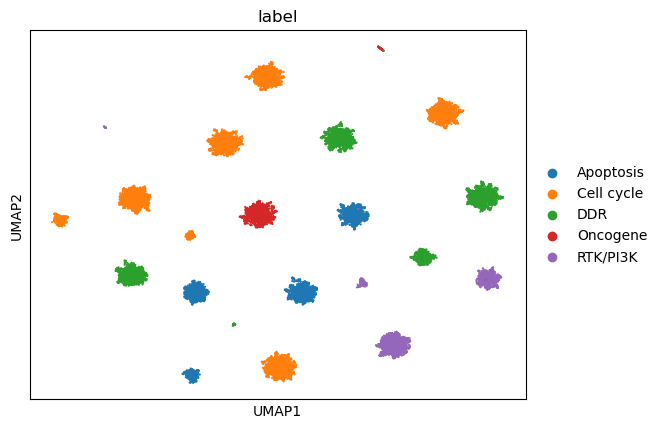

In [40]:
sc.pl.umap(
    adata,
    color="label",
    # Setting a smaller point size to get prevent overlap
    size=10,
    save='via_emb_umap_perturbed.pdf'
)

In [41]:
path = "/work/magroup/kaileyhu/res/perturbed/gf_12L_30M_i2048_SL/gene2vec_df"
name = "gene2vec_no_film"
cv = 1
metrics_dict_path = f"/work/magroup/kaileyhu/res/ablations/cv{cv}/{name}.pkl"

with open("/work/magroup/kaileyhu/datasets/SynLethSampled/all_pairs_NSP_EXP_5x.pkl", "rb") as f:
    pair_list = pkl.load(f)

print(f"Running general model without FiLM pretraining using EXP5 CV{cv}")

print("Viability embedding generation")
delta_df = pd.read_hdf(f"{path}/gene2vec_PERTURBED_128_emb_mat.h5", "table")
print(f"df shape is {df.shape}")

Running general model without FiLM pretraining using EXP5 CV1
Viability embedding generation
df shape is (1951670, 36)


In [42]:
delta_df['gene'] = list(map(get_genes_from_index, list(delta_df.index)))

In [43]:
delta_df2 = delta_df[delta_df['gene'].isin(pathway_ids)]

In [44]:
delta_df2['gene name'] = delta_df2['gene'].apply(lambda x : pathway_id_maps[x])
delta_df2['state'] = delta_df2['gene name'].apply(lambda x : pathway_map[x])

/tmp/ipykernel_1343478/1990156475.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  delta_df2['gene name'] = delta_df2['gene'].apply(lambda x : pathway_id_maps[x])
/tmp/ipykernel_1343478/1990156475.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  delta_df2['state'] = delta_df2['gene name'].apply(lambda x : pathway_map[x])


In [45]:
delta_df2_embs = delta_df2.drop(columns = ['viability score', 'gene', 'gene name', 'state'])

In [46]:
# delta_df2_embs = delta_df2_embs.drop(columns = [f"gene {i}" for i in range(128)])

In [47]:
adata2 = sc.AnnData(delta_df2_embs)

In [48]:
adata2.obs['label'] = delta_df2['state']

In [49]:
sc.pp.neighbors(adata2)
sc.tl.umap(adata2)

/home/kaileyhu/anaconda3/envs/geneformer/lib/python3.9/site-packages/scanpy/tools/_utils.py:41: UserWarning: You’re trying to run this on 640 dimensions of `.X`, if you really want this, set `use_rep='X'`.
         Falling back to preprocessing with `sc.pp.pca` and default params.
  warnings.warn(


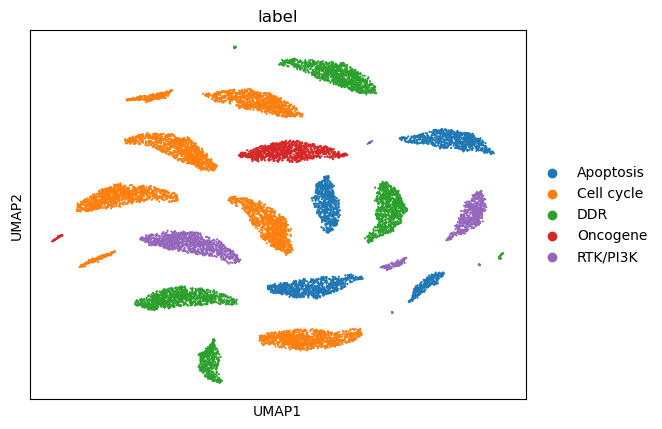

In [52]:
sc.pl.umap(
    adata2,
    color="label",
    # Setting a smaller point size to get prevent overlap
    size=10,
    save='delta_emb_with_gene_umap_perturbed.pdf'
)

In [66]:
import numpy as np

def calculate_cosine_similarity_numpy(vector1, vector2):
    vector1_np = np.array(vector1)
    vector2_np = np.array(vector2)

    dot_product = np.dot(vector1_np, vector2_np)
    magnitude1 = np.linalg.norm(vector1_np)
    magnitude2 = np.linalg.norm(vector2_np)

    if magnitude1 == 0 or magnitude2 == 0:
        return 0

    return dot_product / (magnitude1 * magnitude2)

In [83]:
df_subset = d_df.iloc[: 1000000]

In [84]:
df_subset.iloc[0]

patient                     ACH-000486
gene 1                           CIDEA
gene 2                            NAE1
gene 1 ensembl    gene_ENSG00000176194
gene 2 ensembl    gene_ENSG00000159593
                          ...         
60                           -3.603586
61                           -5.610877
62                           -4.834822
63                           -7.825866
SL                               False
Name: (ACH-000486, gene_ENSG00000176194, gene_ENSG00000159593), Length: 70, dtype: object

In [85]:
df_subset['cos_sim'] = df_subset.progress_apply(lambda row : calculate_cosine_similarity_numpy(row.iloc[5:37], row.iloc[37:69]), axis = 1)

100%|██████████| 1000000/1000000 [02:04<00:00, 8016.90it/s]
/tmp/ipykernel_1245517/4089805897.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_subset['cos_sim'] = df_subset.progress_apply(lambda row : calculate_cosine_similarity_numpy(row.iloc[5:37], row.iloc[37:69]), axis = 1)


In [77]:
df_subset['SL'].unique()

array([False,  True])

In [82]:
np.average(df_subset[df_subset['SL'] == True]['cos_sim'])

0.6705944815438597

In [81]:
np.average(df_subset[df_subset['SL'] == False]['cos_sim'])

0.6693862210566447

In [16]:
# get pearson correlation
import pickle as pkl
from scipy import stats
import numpy as np

In [9]:
path = "/work/magroup/kaileyhu/res/ablations/cv1/pretraining_stats.pkl"
with open(path, "rb") as f:
    metrics = pkl.load(f)

In [14]:
pearsons = []
for i in range (len(metrics)):
    y_pred, y_true = metrics[i]
    correlation_coefficient, p_value = stats.pearsonr(y_pred, y_true)
    pearsons.append(correlation_coefficient)

In [17]:
np.mean(pearsons), np.std(pearsons)

(0.9228008147921976, 0.00031762294365406016)

In [18]:
path = "/work/magroup/kaileyhu/res/ablations/cv1/pretraining_perturbed.pkl"
with open(path, "rb") as f:
    metrics = pkl.load(f)

In [21]:
path = "/work/magroup/kaileyhu/res/ablations/cv1/pretraining_delta.pkl"
with open(path, "rb") as f:
    metrics = pkl.load(f)

pearsons = []
for i in range (len(metrics)):
    y_pred, y_true = metrics[i]
    correlation_coefficient, p_value = stats.pearsonr(y_pred, y_true)
    pearsons.append(correlation_coefficient)

np.mean(pearsons), np.std(pearsons)

(0.07748433750863808, 0.0033791719556245906)